**This notebook is not to be taken as financial advice. I am not a qualified professional, so this notebook is only meant to be used for educational/entertainment purposes. Investing/trading can lead to losses.**

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display

from typing import List, Tuple
from functools import cache  # Python 3.9 required

import yfinance as yf

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 9

In [3]:
TREASURY_BILL_RATE = 0.11  #%, Jan 2021
TRADING_DAYS_PER_YEAR = 250

In [4]:
# Needed for type hinting
class Asset:
  pass


def get_log_period_returns(price_history: pd.DataFrame):
  close = price_history['Close'].values  
  return np.log(close[1:] / close[:-1]).reshape(-1, 1)


# daily_price_history has to at least have a column, called 'Close'
class Asset:
  def __init__(self, name: str, daily_price_history: pd.DataFrame):
    self.name = name
    self.daily_returns = get_log_period_returns(daily_price_history)
    self.expected_daily_return = np.mean(self.daily_returns)
  
  @property
  def expected_return(self):
    return TRADING_DAYS_PER_YEAR * self.expected_daily_return

  def __repr__(self):
    return f'<Asset name={self.name}, expected return={self.expected_return}>'

  @staticmethod
  @cache
  def covariance_matrix(assets: Tuple[Asset]):  # tuple for hashing in the cache
    product_expectation = np.zeros((len(assets), len(assets)))
    for i in range(len(assets)):
      for j in range(len(assets)):
        if i == j:
          product_expectation[i][j] = np.mean(assets[i].daily_returns * assets[j].daily_returns)
        else:
          product_expectation[i][j] = np.mean(assets[i].daily_returns @ assets[j].daily_returns.T)
    
    product_expectation *= (TRADING_DAYS_PER_YEAR - 1) ** 2

    expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    product_of_expectations = expected_returns @ expected_returns.T

    return product_expectation - product_of_expectations


def random_weights(weight_count):
    weights = np.random.random((weight_count, 1))
    weights /= np.sum(weights)
    return weights.reshape(-1, 1)


class Portfolio:
  def __init__(self, assets: Tuple[Asset]):
    self.assets = assets
    self.asset_expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
    self.covariance_matrix = Asset.covariance_matrix(assets)
    self.weights = random_weights(len(assets))
    
  def unsafe_optimize_with_risk_tolerance(self, risk_tolerance: float):
    res = minimize(
      lambda w: self._variance(w) - risk_tolerance * self._expected_return(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)
  
  def optimize_with_risk_tolerance(self, risk_tolerance: float):
    assert risk_tolerance >= 0.
    return self.unsafe_optimize_with_risk_tolerance(risk_tolerance)
  
  def optimize_with_expected_return(self, expected_portfolio_return: float):
    res = minimize(
      lambda w: self._variance(w),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
        {'type': 'eq', 'fun': lambda w: self._expected_return(w) - expected_portfolio_return},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def optimize_sharpe_ratio(self):
    # Maximize Sharpe ratio = minimize minus Sharpe ratio
    res = minimize(
      lambda w: -(self._expected_return(w) - TREASURY_BILL_RATE / 100) / np.sqrt(self._variance(w)),
      random_weights(self.weights.size),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(self.weights.size)]
    )

    assert res.success, f'Optimization failed: {res.message}'
    self.weights = res.x.reshape(-1, 1)

  def _expected_return(self, w):
    return (self.asset_expected_returns.T @ w.reshape(-1, 1))[0][0]
  
  def _variance(self, w):
    return (w.reshape(-1, 1).T @ self.covariance_matrix @ w.reshape(-1, 1))[0][0]

  @property
  def expected_return(self):
    return self._expected_return(self.weights)
  
  @property
  def variance(self):
    return self._variance(self.weights)

  def __repr__(self):
    return f'<Portfolio assets={[asset.name for asset in self.assets]}, expected return={self.expected_return}, variance={self.variance}>'

In [5]:
def yf_retrieve_data(tickers: List[str]):
  dataframes = []

  for ticker_name in tickers:
    ticker = yf.Ticker(ticker_name)
    history = ticker.history(period='10y')

    if history.isnull().any(axis=1).iloc[0]:  # the first row can have NaNs
      history = history.iloc[1:]
  
    assert not history.isnull().any(axis=None), f'history has NaNs in {ticker_name}'
    dataframes.append(history)
  
  return dataframes

## Usage example

In [6]:
stocks = ['AAPL', 'AMZN', 'GOOG', 'BRK-B', 'JNJ', 'JPM']

daily_dataframes = yf_retrieve_data(stocks)
assets = tuple([Asset(name, daily_df) for name, daily_df in zip(stocks, daily_dataframes)])

In [7]:
assets

(<Asset name=AAPL, expected return=0.21303473096895575>,
 <Asset name=AMZN, expected return=0.20383438644171156>,
 <Asset name=GOOG, expected return=0.17603641562777242>,
 <Asset name=BRK-B, expected return=0.12607466046508473>,
 <Asset name=JNJ, expected return=0.11961944936028944>,
 <Asset name=JPM, expected return=0.14629494148897396>)

AssertionError: Optimization failed: Positive directional derivative for linesearch

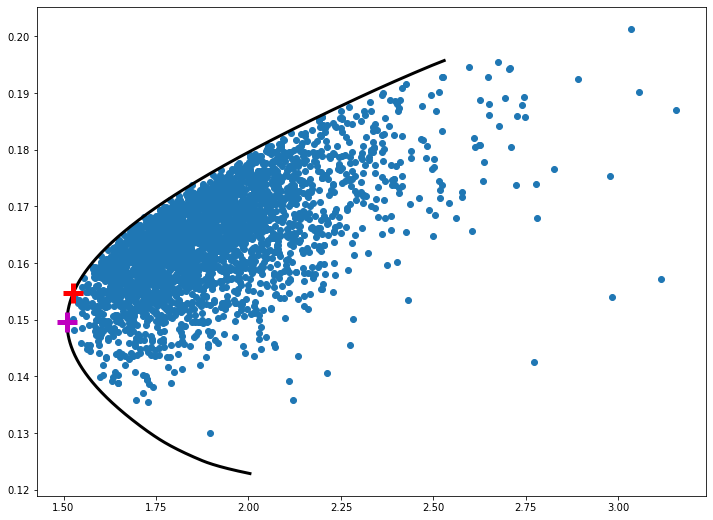

In [8]:
X = []
y = []

# Drawing random portfolios
for i in range(3000):
  portfolio = Portfolio(assets)
  X.append(np.sqrt(portfolio.variance))
  y.append(portfolio.expected_return)

plt.scatter(X, y, label='Random portfolios')

# Drawing the efficient frontier
X = []
y = []
for rt in np.linspace(-300, 200, 1000):
  portfolio.unsafe_optimize_with_risk_tolerance(rt)
  X.append(np.sqrt(portfolio.variance))
  y.append(portfolio.expected_return)

plt.plot(X, y, 'k', linewidth=3, label='Efficient frontier')

# Drawing optimized portfolios
portfolio.optimize_with_risk_tolerance(0)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'm+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(0)')

portfolio.optimize_with_risk_tolerance(20)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'r+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(20)')

portfolio.optimize_with_expected_return(0.25)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'g+', markeredgewidth=5, markersize=20, label='optimize_with_expected_return(0.25)')

portfolio.optimize_sharpe_ratio()
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'y+', markeredgewidth=5, markersize=20, label='optimize_sharpe_ratio()')

plt.xlabel('Portfolio standard deviation')
plt.ylabel('Portfolio expected (logarithmic) return')
plt.legend(loc='lower right')
plt.show()

In [ ]:
pd.options.display.float_format = "{:,.5f}".format

In [ ]:
portfolio = Portfolio(assets)
portfolio.optimize_with_risk_tolerance(0)
riskless_weights = portfolio.weights.flatten()

portfolio.optimize_with_risk_tolerance(20)
weights_risk_tolerance = portfolio.weights.flatten()

portfolio.optimize_with_expected_return(0.25)
weights_return = portfolio.weights.flatten()

portfolio.optimize_sharpe_ratio()
weights_sharpe = portfolio.weights.flatten()

display(
  pd.DataFrame(
    list(
      zip(
        [asset.name for asset in portfolio.assets],
        riskless_weights,
        weights_risk_tolerance,
        weights_return,
        weights_sharpe,
      )
    ),
    columns=[
      'asset',
      'optimize_with_risk_tolerance(0)',
      'optimize_with_risk_tolerance(20)',
      'optimize_with_expected_return(0.25)',
      'optimize_sharpe_ratio()',
    ],
  )
)